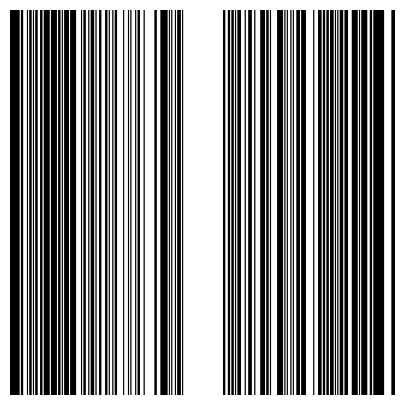

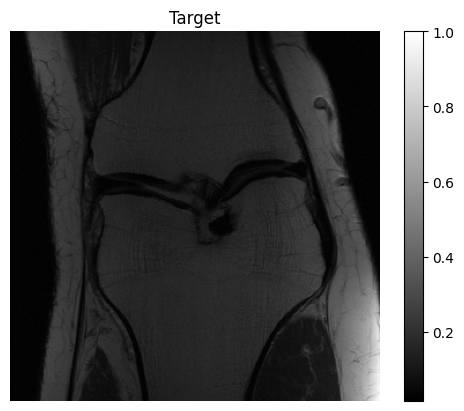

ULA iter    0, grad_norm=1.121e+04, sample_mean=4.384e-11, sample_std=8.195e-03
ULA iter   25, grad_norm=1.630e+04, sample_mean=-1.799e-05, sample_std=1.114e-02
ULA iter   50, grad_norm=1.874e+04, sample_mean=-2.413e-05, sample_std=1.311e-02
ULA iter   75, grad_norm=2.015e+04, sample_mean=-7.462e-05, sample_std=1.459e-02
ULA iter  100, grad_norm=2.102e+04, sample_mean=-7.214e-05, sample_std=1.580e-02
ULA iter  125, grad_norm=2.168e+04, sample_mean=-7.923e-05, sample_std=1.683e-02
ULA iter  150, grad_norm=2.194e+04, sample_mean=-9.476e-05, sample_std=1.768e-02
ULA iter  175, grad_norm=2.212e+04, sample_mean=-1.177e-04, sample_std=1.846e-02
ULA iter  200, grad_norm=2.224e+04, sample_mean=-9.149e-05, sample_std=1.915e-02
ULA iter  225, grad_norm=2.242e+04, sample_mean=-7.958e-05, sample_std=1.976e-02
ULA iter  250, grad_norm=2.256e+04, sample_mean=-5.804e-05, sample_std=2.038e-02
ULA iter  275, grad_norm=2.253e+04, sample_mean=-7.754e-05, sample_std=2.089e-02
ULA iter  300, grad_norm=2.25

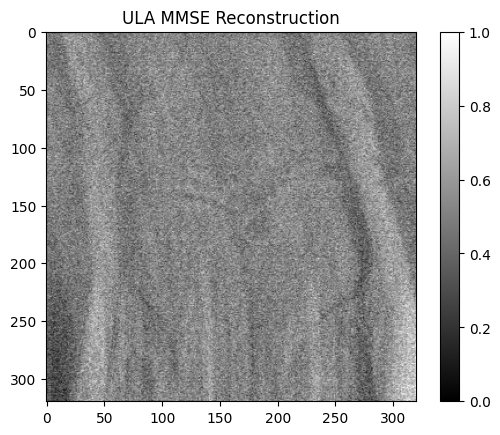

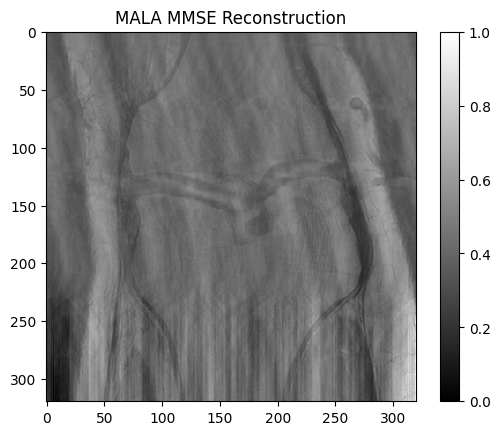

ULA iter    0, grad_norm=1.121e+04, sample_mean=4.384e-11, sample_std=8.195e-03
ULA iter   25, grad_norm=1.627e+04, sample_mean=-3.180e-05, sample_std=1.113e-02
ULA iter   50, grad_norm=1.877e+04, sample_mean=-1.256e-05, sample_std=1.314e-02
ULA iter   75, grad_norm=2.027e+04, sample_mean=-2.877e-05, sample_std=1.461e-02
ULA iter  100, grad_norm=2.107e+04, sample_mean=-2.124e-05, sample_std=1.580e-02
ULA iter  125, grad_norm=2.163e+04, sample_mean=-4.530e-05, sample_std=1.680e-02
ULA iter  150, grad_norm=2.196e+04, sample_mean=-5.447e-05, sample_std=1.768e-02
ULA iter  175, grad_norm=2.217e+04, sample_mean=-5.827e-05, sample_std=1.846e-02
ULA iter  200, grad_norm=2.230e+04, sample_mean=-6.185e-05, sample_std=1.914e-02
ULA iter  225, grad_norm=2.239e+04, sample_mean=-5.768e-05, sample_std=1.978e-02
ULA iter  250, grad_norm=2.240e+04, sample_mean=-9.658e-05, sample_std=2.034e-02
ULA iter  275, grad_norm=2.242e+04, sample_mean=-1.178e-04, sample_std=2.083e-02
ULA iter  300, grad_norm=2.24

In [2]:
# ULA diagnostics

import os
import sys
import fastmri
import fastmri.data
import fastmri.data.transforms
import h5py
import torch

# Set the path to the root of your project
project_root = os.path.abspath(os.path.join(os.getcwd(), r"C:\Users\kostanjsek\bachelor_project"))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
from utilities.masks import (
    UniformColumnMask,
    VariableDensityMask,
    PseudoRandomColumnMask,
    RadialMask
)
from fastmri.data import transforms as T
from utilities.metrics import psnr
from MAP.map_tv_minimize import MAPEstimator
from fastmri.data.mri_data import SliceDataset
from data.load_knee_mri import load_fastmri_data
from MMSE.mmse_ula import MMSEEstimatorULA
from MMSE.mmse_mala import MMSEEstimatorMALA
import skimage as ski


train_dataset, val_dataset, test_dataset = load_fastmri_data(
    r"C:\Users\kostanjsek\Documents\knee_mri"
)

file_name = r"C:\Users\kostanjsek\Documents\knee_mri\knee_singlecoil_train\singlecoil_train/file1000662.h5"
hf = h5py.File(file_name)

volume_kspace = hf['kspace'][()]
target = hf['reconstruction_rss'][()]

slice_kspace = volume_kspace[20]
slice_target = target[20]  # match slice index to kspace slice
tensor_kspace = T.to_tensor(slice_kspace)


#mask = VariableDensityMask('gaussian', 1.5, seed=30).generate(slice_target.shape)
mask = PseudoRandomColumnMask(slice_target.shape, 2, 1, seed=30).get_mask()

y = mask * np.fft.fft2(slice_target) # mask * slice_kspace
y = y / np.abs(y).max()

#map_estimator = MAPEstimator(mask, 0.95, 0.01, 1e-2) # def-> 0.95, 0.01, 1e-2, 0.1, 100)
ula_estimator = MMSEEstimatorULA(mask, 0.01, 0.1, 1e-2, 1e-6, 350, 2, 150) # stepsize = 1e-2
mala_estimator = MMSEEstimatorMALA(mask, 1, 2, 100e-2, 1e-6, 350, 2, 100)

#map_reconstruct = map_estimator.subgradient_descent(y)


plt.figure(figsize=(5, 5))
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
#plt.title('Pseudo random (Gaussian 1D)')
plt.axis('off')
plt.show()

# target

plt.imshow(slice_target / slice_target.max(), cmap="gray")
plt.title("Target")
plt.colorbar()
plt.axis("off")
plt.show()

# loss
# plt.plot(map_estimator.loss_history)
# plt.title("Loss over iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.yscale('log')
# plt.show()

# gradient
# plt.plot(map_estimator.grad_norm_history)
# plt.title("Gradient norm over iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Gradient norm")
# plt.grid(True)
# #plt.yscale('log')
# plt.show()

# ula mmse
plt.imshow(ula_estimator.compute_mmse_estimate(y), cmap="gray")
plt.title("ULA MMSE Reconstruction")
plt.colorbar()
plt.show()

plt.imshow(mala_estimator.compute_mmse_estimate(y), cmap="gray")
plt.title("MALA MMSE Reconstruction")
plt.colorbar()
plt.show()

psnr_ula = psnr(ula_estimator.compute_mmse_estimate(y), slice_target)
print(print(f"PSNR: {psnr_ula:.2f} dB"))

psnr_mala = psnr(mala_estimator.compute_mmse_estimate(y), (slice_target / slice_target.max()))
print(print(f"PSNR: {psnr_mala:.2f} dB"))